In [7]:
import sys
print(sys.executable)

c:\Users\RISHIVEER YADAV\AppData\Local\Programs\Python\Python39\python.exe


# 3Q) KNN and ANN
In this question we are asked to implement KNN and ANN from scratch given input embeddings

## 3.1) KNN
We are asked to implement KNN from scratch, the inputs are a set of embeddings. Given a query, k and a distance metric, it should return the indices of the k nearest neighbours from the database.

In [19]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def euclidean_distance(a, b):
    a_sq = np.sum(a**2, axis=1, keepdims=True)
    b_sq = np.sum(b**2, axis=1)
    ab = np.dot(a, b.T)
    return np.sqrt(a_sq - 2 * ab + b_sq)

def cosine_distance(a, b):
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)
    return 1 - np.dot(a_norm, b_norm.T)

In [20]:
def knn(database, query, k, distance_metric):
    indices = []
    if distance_metric == 'euclidean':
        distance = euclidean_distance(query, database)
    elif distance_metric == 'cosine':
        distance = cosine_distance(query, database)
    else:
        raise ValueError("Distance Metric not supported. Use only Euclidean or Cosine distances")
    indices.append(np.argsort(distance, axis=1)[:, :k])
    return np.vstack(indices)

In [12]:
def classify(database, labels, query, k, distance_metric):
    neighbour_indices = knn(database, query, k, distance_metric)
    neighbour_labels = labels[neighbour_indices]
    predictions = np.array([np.bincount(neighbour).argmax() for neighbour in neighbour_labels])
    return predictions

def mean_reciprocal_rank(ranked_indices, query_labels, database_labels):
    mrr_values = []
    for i, (ranks, true_label) in enumerate(zip(ranked_indices, query_labels)):
        # Find the first occurrence of the correct class
        correct_indices = np.where(database_labels[ranks] == true_label)[0]
        if len(correct_indices) > 0:
            mrr_values.append(1.0 / (correct_indices[0] + 1))
        else:
            mrr_values.append(0.0)
    return np.mean(mrr_values)

def precision_at_k(ranked_indices, query_labels, database_labels, k=100):
    precisions = []
    for ranks, true_label in zip(ranked_indices, query_labels):
        retrieved_labels = database_labels[ranks[:k]]
        precisions.append(np.sum(retrieved_labels == true_label) / k)
    return np.mean(precisions)

def hit_rate(ranked_indices, query_labels, database_labels):
    hits = []
    for ranks, true_label in zip(ranked_indices, query_labels):
        retrieved_labels = database_labels[ranks]
        hits.append(1 if true_label in retrieved_labels else 0)
    return np.mean(hits)

In [13]:
try:
    train_embeddings = torch.load('./SMAI A1/train_embeddings.pth',map_location=torch.device('cpu')).numpy()
    test_embeddings = torch.load('./SMAI A1/test_embeddings.pth',map_location=torch.device('cpu')).numpy()
    text_embeddings = torch.load('./SMAI A1/text_embedding.pth',map_location=torch.device('cpu')).numpy()
    train_labels = torch.load('./SMAI A1/train_labels.pth',map_location=torch.device('cpu')).numpy()
    test_labels = torch.load('./SMAI A1/test_labels.pth',map_location=torch.device('cpu')).numpy()

    train_embeddings /= np.linalg.norm(train_embeddings, axis=1, keepdims=True)
    test_embeddings /= np.linalg.norm(test_embeddings, axis=1, keepdims=True)
    text_embeddings /= np.linalg.norm(text_embeddings, axis=1, keepdims=True)
except Exception as e:
    print('Error has occured:', e)

In [15]:
# Classification using train embeddings
for k in [1, 5, 10]:
    pred_euc = classify(train_embeddings, train_labels, test_embeddings, k, distance_metric='euclidean')
    pred_cos = classify(train_embeddings, train_labels, test_embeddings, k, distance_metric='cosine')
    print(f'k={k} Euclidean Accuracy:', accuracy_score(test_labels, pred_euc))
    print(f'k={k} Cosine Accuracy:', accuracy_score(test_labels, pred_cos))

# Classification using text embeddings
pred_text = classify(text_embeddings, np.arange(10), test_embeddings, k=1, distance_metric='cosine')
print('Text-based Classification Accuracy:', accuracy_score(test_labels, pred_text))

# Text-to-Image Retrieval
text_labels = np.arange(10)
neighbours_text_to_image = knn(train_embeddings, text_embeddings, k=100, distance_metric='cosine')
print('\nText-to-Image Retrieval Metrics:')
print('MRR:', mean_reciprocal_rank(neighbours_text_to_image, text_labels, train_labels))
print('Precision@100:', precision_at_k(neighbours_text_to_image, text_labels, train_labels))
print('Hit Rate:', hit_rate(neighbours_text_to_image, text_labels, train_labels))

# Image-to-Image Retrieval
neighbours_image_to_image = knn(train_embeddings, test_embeddings, k=100, distance_metric='cosine')
print('\nImage-to-Image Retrieval Metrics:')
print('MRR:', mean_reciprocal_rank(neighbours_image_to_image, test_labels, train_labels))
print('Precision@100:', precision_at_k(neighbours_image_to_image, test_labels, train_labels))
print('Hit Rate:', hit_rate(neighbours_image_to_image, test_labels, train_labels))

k=1 Euclidean Accuracy: 0.9048
k=1 Cosine Accuracy: 0.9048
k=5 Euclidean Accuracy: 0.9182
k=5 Cosine Accuracy: 0.9182
k=10 Euclidean Accuracy: 0.9194
k=10 Cosine Accuracy: 0.9194
Text-based Classification Accuracy: 0.8781

Text-to-Image Retrieval Metrics:
MRR: 1.0
Precision@100: 0.974
Hit Rate: 1.0

Image-to-Image Retrieval Metrics:
MRR: 0.934796151331504
Precision@100: 0.841083
Hit Rate: 0.9996


## 3.2) Locality Sensitive Hashing
We are asked to implement LSH based on the reference article using random hyperplanes. Performing search with LSH consists of three steps:

1) Index all of our vectors into their hashed vectors.
2) Introduce our query vector (search term). It is hashed using the same LSH function.
3) Compare our hashed query vector to all other hash buckets via Hamming distance — identifying the nearest.

In [32]:
# Function to create and normalize random hyperplanes
def create_hyperplanes(nplanes, dimensions):
    hyperplanes = np.random.randn(nplanes, dimensions)
    return hyperplanes / np.linalg.norm(hyperplanes, axis=1)[:, np.newaxis]

# Function to hash vectors into buckets using hyperplane projections. It returns a dictionary mapping hash strings to lists of vector indices
def hash_vectors(vectors, hyperplanes):
    buckets = {}
    projections = np.dot(vectors, hyperplanes.T)
    binary_hashes = (projections > 0).astype(int)

    for i, binary_hash in enumerate(binary_hashes):
        hash_str = ''.join(binary_hash.astype(int).astype(str))
        if hash_str in buckets:
            buckets[hash_str].append(i)
        else:
            buckets[hash_str] = [i]
    return buckets

# Function to calculate the Hamming distance
def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

# Function to perform LSH, ie., find k nearest neighbours for a query vector using LSH
def query_lsh(query_vector, hyperplanes, buckets, k, max_hamming_distance):
    projections = np.dot(query_vector, hyperplanes.T)
    hashed_query = ''.join(['1' if projection > 0 else '0' for projection in projections])

    # collecting cadidates from nearby search
    candidates = []

    if hashed_query in buckets:
        candidates.extend(buckets[hashed_query])

    # checking the neighbouring buckets
    for bucket_hash in list(buckets.key()):
        if len(bucket_hash) != len(hashed_query):
            continue
        distance = hamming_distance(hashed_query, bucket_hash)
        if 0 < distance <= max_hamming_distance:
            candidates.extend(buckets[bucket_hash])

    if len(candidates) < k:
        return candidates
    return np.random.choice(candidates, k, replace=False).tolist()

def analyze_bucket_distribution(buckets):
    """Analyze the distribution of bucket sizes"""
    bucket_sizes = [len(bucket) for bucket in buckets.values()]
    sizes_dict = {}
    for size in bucket_sizes:
        if size not in sizes_dict:
            sizes_dict[size] = 1
        else:
            sizes_dict[size] += 1
    
    unique_sizes = sorted(sizes_dict.keys())
    size_counts = [sizes_dict[size] for size in unique_sizes]
    return unique_sizes, size_counts

def plot_bucket_distributions(hyperplane_counts, train_embeddings):
    """Plot bucket size distributions for different numbers of hyperplanes"""
    fig, axes = plt.subplots(len(hyperplane_counts), 1, figsize=(10, 4*len(hyperplane_counts)))
    if len(hyperplane_counts) == 1:
        axes = [axes]
    
    for ax, num_planes in zip(axes, hyperplane_counts):
        hyperplanes = create_hyperplanes(num_planes, train_embeddings.shape[1])
        buckets = hash_vectors(train_embeddings, hyperplanes)
        sizes, counts = analyze_bucket_distribution(buckets)
        
        ax.bar(sizes, counts)
        ax.set_title(f'Bucket Size Distribution ({num_planes} hyperplanes)')
        ax.set_xlabel('Bucket Size')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

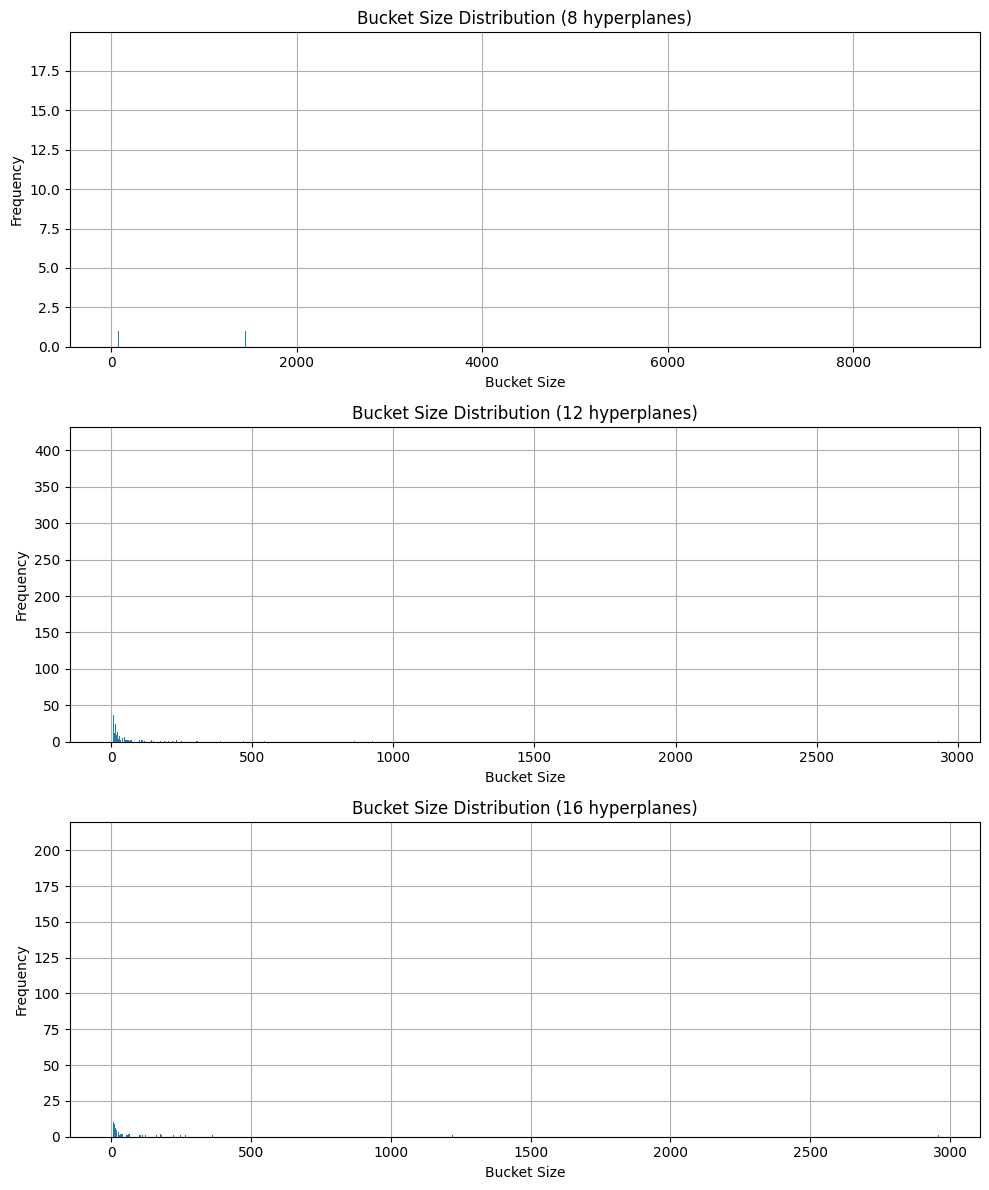

In [33]:
# print(np.shape(train_embeddings))

hyperplane_counts = [8, 12, 16]
plot_bucket_distributions(hyperplane_counts, train_embeddings)